## Previsao de Embarque 
- Simples 
- Sem Serie Temporal
- Regressao Linear
- Random Forest
- Com Grid Search
- Bagging, Stacking e Boosting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
import datetime as dt

import warnings

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
#from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import display
from pprint import pprint
from math import sqrt

#from shutil import unpack_archive
#unpack_archive('./df_input.zip', './')

## Filtro de Onibus e definicoes de features/target

In [2]:
# Reading Data file (geolocalized)
data = pd.read_csv('./data_input_zerofill.csv', sep=';', delimiter=';')

busline_filter = 325
data_model = data.copy()

#d_ano,  estao disponiveis para inserir once eu tive mais de 1 ano de dados
feature_names = [
    'hour_sin', 'hour_cos', 
    'd_mes', 'd_ano', 'mes', 'semana_do_mes', 
    'domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 
    'feriado', 'vespera_feriado']

target = 'validations_per_hour'

In [3]:
day_of_week_translator = {
    0: "Domingo",
    1: "Segunda",
    2: "Terca",
    3: "Quarta",
    4: "Quinta",
    5: "Sexta",
    6: "Sabado"
}

feriados = [
            ['Ano Novo', 1, 1],
            ['Carnaval', 24, 2],
            ['Carnaval', 25, 2],
            ['Carnaval', 26, 2],
            ['Dia de São José', 19, 3],
            ['Data Magna', 25, 3],
            ['Sexta-Feira Santa', 10, 4],
            ['Aniversário de Fortaleza', 13, 4],
            ['Tiradentes', 21, 4],
            ['Dia do Trabalho', 1, 5],
            ['Corpus Christi', 28, 5],
            ['N. Senhora da Assunção', 27, 5],
            ['Independência do Brasil', 7, 9],
            ['N. Senhora de Aparecida', 12, 10],
            ['Dia de Finados', 2, 11],
            ['Proclamação da Republica', 15, 11],
            ['Natal', 25, 12],
]

vesperas = [
            ['Ano Novo', 31, 12],
            ['Carnaval', 23, 2],
            ['Dia de São José', 18, 3],
            ['Data Magna', 24, 3],
            ['Sexta-Feira Santa', 9, 4],
            ['Aniversário de Fortaleza', 12, 4],
            ['Tiradentes', 20, 4],
            ['Dia do Trabalho', 30, 4],
            ['N. Senhora da Assunção', 26, 5],
            ['Independência do Brasil', 6, 9],
            ['N. Senhora de Aparecida', 11, 10],
            ['Dia de Finados', 1, 11],
            ['Proclamação da Republica', 14, 11],
            ['Natal', 24, 12],
]

In [4]:
data_model

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes
0,1,2020-03-01 00:00:00,0,6,0.000000,1.000000,0,1,61,3,1
1,1,2020-03-01 01:00:00,0,6,0.269797,0.962917,1,1,61,3,1
2,1,2020-03-01 02:00:00,0,6,0.519584,0.854419,2,1,61,3,1
3,1,2020-03-01 03:00:00,0,6,0.730836,0.682553,3,1,61,3,1
4,1,2020-03-01 04:00:00,0,6,0.887885,0.460065,4,1,61,3,1
...,...,...,...,...,...,...,...,...,...,...,...
1604349,999,2020-12-01 08:00:00,12,1,0.816970,-0.576680,8,1,336,12,0
1604350,999,2020-12-01 09:00:00,1,1,0.631088,-0.775711,9,1,336,12,0
1604351,999,2020-12-01 10:00:00,1,1,0.398401,-0.917211,10,1,336,12,0
1604352,999,2020-12-01 11:00:00,5,1,0.136167,-0.990686,11,1,336,12,0


In [5]:
one_hot_encoder = OneHotEncoder(sparse=False)

data_model[['domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado']] = one_hot_encoder.fit_transform(data_model['d_semana'].values.reshape(-1,1))
data_model['feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in feriados) else 0 for x in list(zip(data_model.d_mes, data_model.mes))]
data_model['vespera_feriado'] = [1 if any((x[0] == d and x[1] == m) for (_, d, m) in vesperas) else 0 for x in list(zip(data_model.d_mes, data_model.mes))]

top100_linhas = data_model.linha.value_counts().index[:100]
top100_linhas_data_model = data_model[data_model.linha.isin(top100_linhas)].loc[data['mes'] != 1]

line_data_model = data_model.loc[data['linha'] == busline_filter].loc[data['mes'] != 1].copy()

In [6]:
top100_linhas_data_model.to_csv("./dados-para-modelos/top100_linhas_data_model.csv", index=False)

In [7]:
#display(X)

In [8]:
#display(y)

---------------------------------------------------------------------------- Fim Setup ----------------------------------------------------------------------------  
# Criacao dos Modelos

In [9]:
model_list = []

In [10]:
def get_performance(model):
    y_test_predict = model.predict(X_test)
    mse = mean_squared_error(Y_test, y_test_predict)
    rmse = (np.sqrt(mse))
    r2 = r2_score(Y_test, y_test_predict)
    mae = mean_absolute_error(Y_test, y_test_predict)
    #mape = mean_absolute_percentage_error(Y_test, y_test_predict)
    performance_scoring = [
        r2,
        rmse,
        mae,
        #mape
    ]
    #performance_scoring = pd.DataFrame(performance_scoring,columns=['Metrica', 'Score'])
    #performance_scoring['Score'] = performance_scoring['Score'].astype('float64')
    return performance_scoring

### Grid Search

In [11]:
LinearRegressionModel = LinearRegression()
RandomForestModel = RandomForestRegressor()

#### Linear Regression Model Parameters

In [12]:
# print("Linear Regression  Params ----> ")
# pprint(LinearRegressionModel.get_params())

copy_X = [True, False]
fit_intercept = [True, False]
n_jobs = [2, 4, 6, 8]
normalize = [True, False]

# Create the random grid
random_grid_linearregression = {'copy_X': copy_X, 'fit_intercept': fit_intercept, 'n_jobs': n_jobs, 'normalize': normalize}

#### Random Forest Model Parameters

In [13]:
# print("Random Forest Model Params ----> ")
# pprint(RandomForestModel.get_params())

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 1000, num = 10)]

n_jobs = [2, 4, 6, 8]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid_randomforest = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'n_jobs': n_jobs}

In [14]:
X = line_data_model.filter(feature_names, axis=1)
y = line_data_model.validations_per_hour

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
LinearRegressionModel = LinearRegression()
RandomForestModel = RandomForestRegressor()
gridsearch_result_randomforest = RandomizedSearchCV(estimator = RandomForestModel, param_distributions = random_grid_randomforest, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
gridsearch_result_linearregression = RandomizedSearchCV(estimator = LinearRegressionModel, param_distributions = random_grid_linearregression, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

gridsearch_result_randomforest.fit(X_train, Y_train)
gridsearch_result_linearregression.fit(X_train, Y_train)

print("Random Forest Best Parameters -----> ")
pprint(gridsearch_result_randomforest.best_params_)

print("Linear Regression Best Parameters -----> ")
pprint(gridsearch_result_linearregression.best_params_)

gridsearched_random_randomforest = gridsearch_result_randomforest.best_estimator_
gridsearch_random_linearregression = gridsearch_result_linearregression.best_estimator_

default_linearregression_model = LinearRegressionModel.fit(X_train, Y_train)
default_randomforest_model = RandomForestModel.fit(X_train, Y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\victo\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 32 is smaller than n_iter=100. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Random Forest Best Parameters -----> 
{'bootstrap': True,
 'max_depth': 110,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 237,
 'n_jobs': 2}
Linear Regression Best Parameters -----> 
{'copy_X': True, 'fit_intercept': False, 'n_jobs': 2, 'normalize': True}


In [15]:
sample = X.sample(n=1)
sample

,hour_sin,hour_cos,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
660398,0.398401,-0.917211,5,279,10,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [16]:
print("###  1 Modelo Por Linha (dado completo de treino)")

performance_default_linearregression_model = get_performance(default_linearregression_model)
performance_default_randomforest_model = get_performance(default_randomforest_model)
performance_gridsearched_linearregression_model = get_performance(gridsearch_random_linearregression)
performance_gridsearched_randomforest_model = get_performance(gridsearched_random_randomforest)

print("\n----------------------------------------------------\n")
print('Regressao Linear [DEFAULT]: \n', performance_default_linearregression_model)
print("\n----------------------------------------------------\n")
print('Random Forest [DEFAULT]: \n', performance_default_randomforest_model)
print("\n----------------------------------------------------\n")
print('Regressao Linear [GRID SEARCH]: \n', performance_gridsearched_linearregression_model)
print("\n----------------------------------------------------\n")
print('Random Forest [GRID SEARCH]: \n', performance_gridsearched_randomforest_model)
print("\n----------------------------------------------------\n")

print("\nUtilizando sample aleatorio de dado para teste de previsao: ")

predict_res = default_linearregression_model.predict(sample)

print("Regressao Linear -> resultado do predict de test: ", predict_res)

predict_res2 = default_randomforest_model.predict(sample)
print("Random Forest -> resultado do predict de test: ", predict_res2)

random_res = gridsearch_random_linearregression.predict(sample)
print("Regressao Linear Best Grid Searched -> resultado do predict de test: ", predict_res2)

random_res = gridsearched_random_randomforest.predict(sample)
print("Random Forest Best Grid Searched -> resultado do predict de test: ", predict_res2)

display(data_model.loc[sample.index[0]:sample.index[0]])

print('LINHA UTILIZADA PARA OS TESTES: ', busline_filter)

performance_total = [performance_default_linearregression_model,
    performance_default_randomforest_model,
    performance_gridsearched_linearregression_model,
    performance_gridsearched_randomforest_model]

performance_total = pd.DataFrame.from_records(performance_total, columns=['R2', 'RMSE', 'MAE'], 
    index=['LinearReg Default', 'RandomForest Default', 'LinearReg GridSearched', 'RandomForest GridSearched'])
performance_total

###  1 Modelo Por Linha (dado completo de treino)

----------------------------------------------------

Regressao Linear [DEFAULT]: 
 [0.28273266440762923, 13.910908256525596, 9.092768259633653]

----------------------------------------------------

Random Forest [DEFAULT]: 
 [0.8393356154947291, 6.583771763546934, 3.778995042356566]

----------------------------------------------------

Regressao Linear [GRID SEARCH]: 
 [0.28273266440762934, 13.910908256525593, 9.092768259633763]

----------------------------------------------------

Random Forest [GRID SEARCH]: 
 [0.8397095075596942, 6.576106549369066, 3.7625689424723]

----------------------------------------------------


Utilizando sample aleatorio de dado para teste de previsao: 
Regressao Linear -> resultado do predict de test:  [30.05199201]
Random Forest -> resultado do predict de test:  [21.16]
Regressao Linear Best Grid Searched -> resultado do predict de test:  [21.16]
Random Forest Best Grid Searched -> resultado do predi

,linha,data_hora,validations_per_hour,d_semana,hour_sin,hour_cos,hora,d_mes,d_ano,mes,semana_do_mes,domingo,segunda,terca,quarta,quinta,sexta,sabado,feriado,vespera_feriado
660398,325,2020-10-05 10:00:00,19,0,0.398401,-0.917211,10,5,279,10,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


LINHA UTILIZADA PARA OS TESTES:  325


,R2,RMSE,MAE
LinearReg Default,0.282733,13.910908,9.092768
RandomForest Default,0.839336,6.583772,3.778995
LinearReg GridSearched,0.282733,13.910908,9.092768
RandomForest GridSearched,0.839710,6.576107,3.762569


## BAGGING

In [17]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
warnings.filterwarnings("ignore") # To ignore warnings
n_jobs = -1 # This parameter conrols the parallel processing. -1 means using all processors.
random_state = 42 # This parameter controls the randomness of the data. Using some int value to get same results everytime this code is run
models_scores = [] # To store model scores               

def bagging_model(estimator):
    """
    I/P
    estimator: The base estimator from which the ensemble is grown.
    O/P
    br_y_pred: Predictions on test data for the base estimator.
    
    """
    regr = BaggingRegressor(base_estimator=estimator,
                            n_estimators=10,
                            max_samples=1.0,
                            bootstrap=True, # Samples are drawn with replacement
                            n_jobs= n_jobs,
                            random_state=random_state).fit(X_train, Y_train)

    br_y_pred = regr.predict(X_test)

    performance = get_performance(regr)
    
    print(f'Performance for base estimator {regr.base_estimator_} = {performance}\n')

    return regr, performance

LinearRegressionModelPipeline = make_pipeline(LinearRegression())
RandomForestModelPipeline = make_pipeline(RandomForestRegressor())

bagging_lr_model, performance_bagging_lr_model = bagging_model(LinearRegressionModelPipeline)
bagging_rf_model, performance_bagging_rf_model = bagging_model(RandomForestModelPipeline)

df2 = pd.DataFrame([performance_bagging_lr_model, performance_bagging_rf_model], columns=['R2','RMSE','MAE'], 
    index=['LinearRegression Bagging', 'RandomForest Bagging'])
performance_total = pd.concat([df2, performance_total])


Performance for base estimator Pipeline(steps=[('linearregression', LinearRegression())]) = [0.2816338060093573, 13.921559981118556, 9.141566316192247]

Performance for base estimator Pipeline(steps=[('randomforestregressor', RandomForestRegressor())]) = [0.8440012163730188, 6.487473034524317, 3.730506660900495]



# STACKING

In [18]:

estimators = [ ('random_forest', RandomForestModelPipeline), ('linear_reg', LinearRegressionModelPipeline)]

stack = StackingRegressor(estimators=estimators, final_estimator= RandomForestModelPipeline, cv= 5, n_jobs= n_jobs, passthrough = True)

stack.fit(X_train, Y_train)

performance = get_performance(stack)

df2 = pd.DataFrame([performance], columns=['R2','RMSE','MAE'], 
    index=['Stacking Regressors'])

performance_total = pd.concat([df2, performance_total])


# BOOSTING

In [19]:
gradient_boosting_regressor= GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state = random_state)

gradient_boosting_regressor.fit(X_train, Y_train)

performance = get_performance(gradient_boosting_regressor)

df2 = pd.DataFrame([performance], columns=['R2','RMSE','MAE'], 
    index=['GradientBoostingRegressor'])

performance_total = pd.concat([df2, performance_total])


In [20]:
performance_total.to_csv('./performances/performance_total_linha'+str(busline_filter)+'.csv', index=False)

In [21]:
performance_total.sort_values('MAE', ascending=True)

,R2,RMSE,MAE
Stacking Regressors,0.847478,6.414773,3.704537
RandomForest Bagging,0.844001,6.487473,3.730507
RandomForest GridSearched,0.839710,6.576107,3.762569
RandomForest Default,0.839336,6.583772,3.778995
GradientBoostingRegressor,0.853538,6.286042,4.010444
LinearReg Default,0.282733,13.910908,9.092768
LinearReg GridSearched,0.282733,13.910908,9.092768
LinearRegression Bagging,0.281634,13.921560,9.141566


### Todos os modelos treinados dentro de *model_list*

In [22]:
model_list = [
    stack,
    gradient_boosting_regressor,
    bagging_rf_model,
    default_randomforest_model,
    #default_linearregression_model,
    #gridsearch_result_linearregression,
    #gridsearch_result_randomforest,
    #bagging_lr_model,
]

## Treinar com 1 mes, prever N semanas

In [26]:
# Jan, Fev, Mar, Abril, Maio
# treina com mar, preve 2 semanas de abril

mes_de_treino = 6
mes_de_previsao = 4

line_mes_data_model = line_data_model[line_data_model.mes == mes_de_treino]

line_mes_data_model_predict = line_data_model[line_data_model.mes == mes_de_previsao]

df_prev = line_mes_data_model_predict[line_mes_data_model_predict.semana_do_mes <=  2].filter(feature_names, axis = 1)
real_values = pd.DataFrame(line_mes_data_model_predict[line_mes_data_model_predict.semana_do_mes <=  2].validations_per_hour)

X = line_mes_data_model.filter(feature_names, axis=1)
y = line_mes_data_model.validations_per_hour
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

predictions = [[],[],[],[]]
performances = list()
df_prev
for i, model in enumerate(model_list):
        model.fit(X_train, Y_train)
        performances.append(get_performance(model))

        for index, row in df_prev.iterrows():
            predictions[i].append(model.predict([row])[0])

df_performance = pd.DataFrame(performances)
df_performance.to_csv('./performances/linha'+str(busline_filter)+'_1mes('+str(mes_de_treino)+')_2semanas('+str(mes_de_previsao)+')_performance.csv', index=False)
df_predict_dados = real_values
df_predict_dados['validations_per_hour_predicted'] = predictions[0]
df_predict_dados.to_csv('./predict-vs-real/linha'+str(busline_filter)+'_1mes('+str(mes_de_treino)+')_2semanas('+str(mes_de_previsao)+')_predict.csv', index=False)

### Treinar com (N-Y) meses, Prever mes (N)

2967


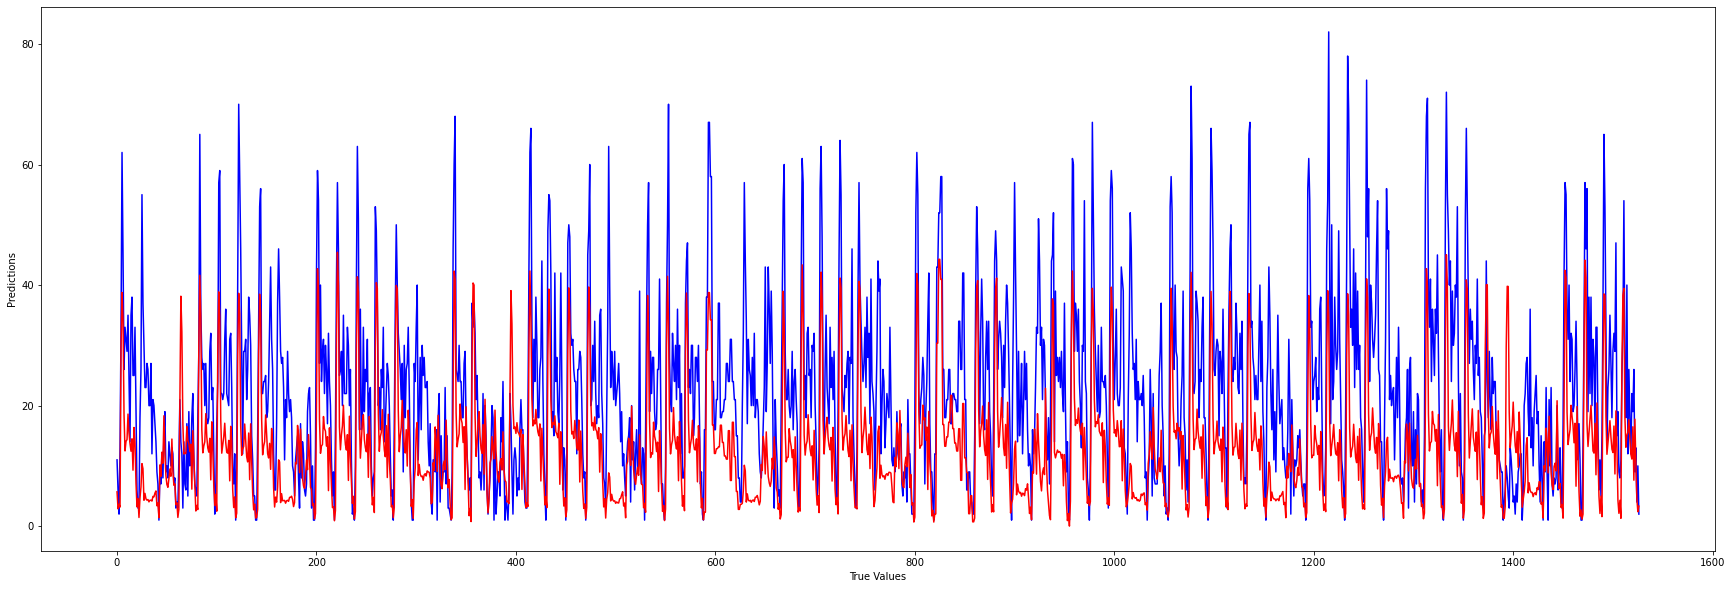

3711


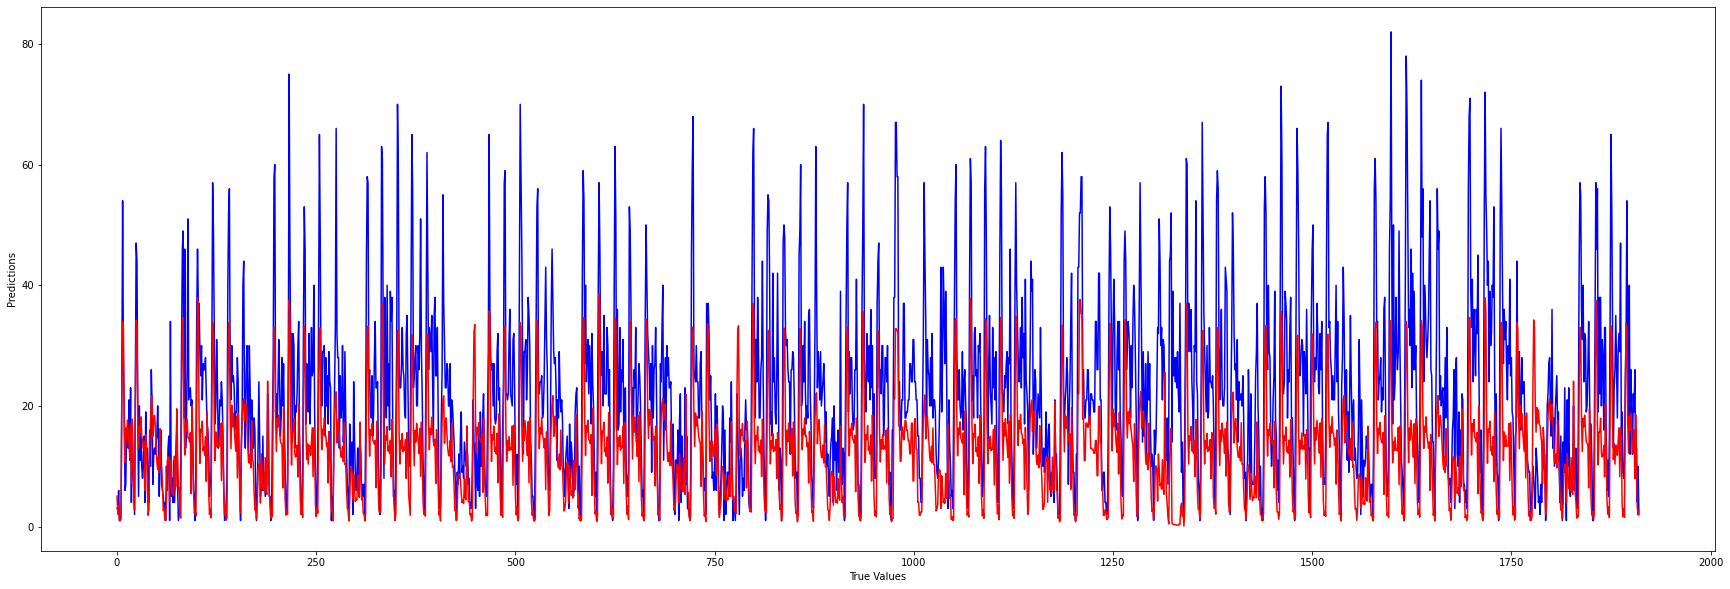

4492


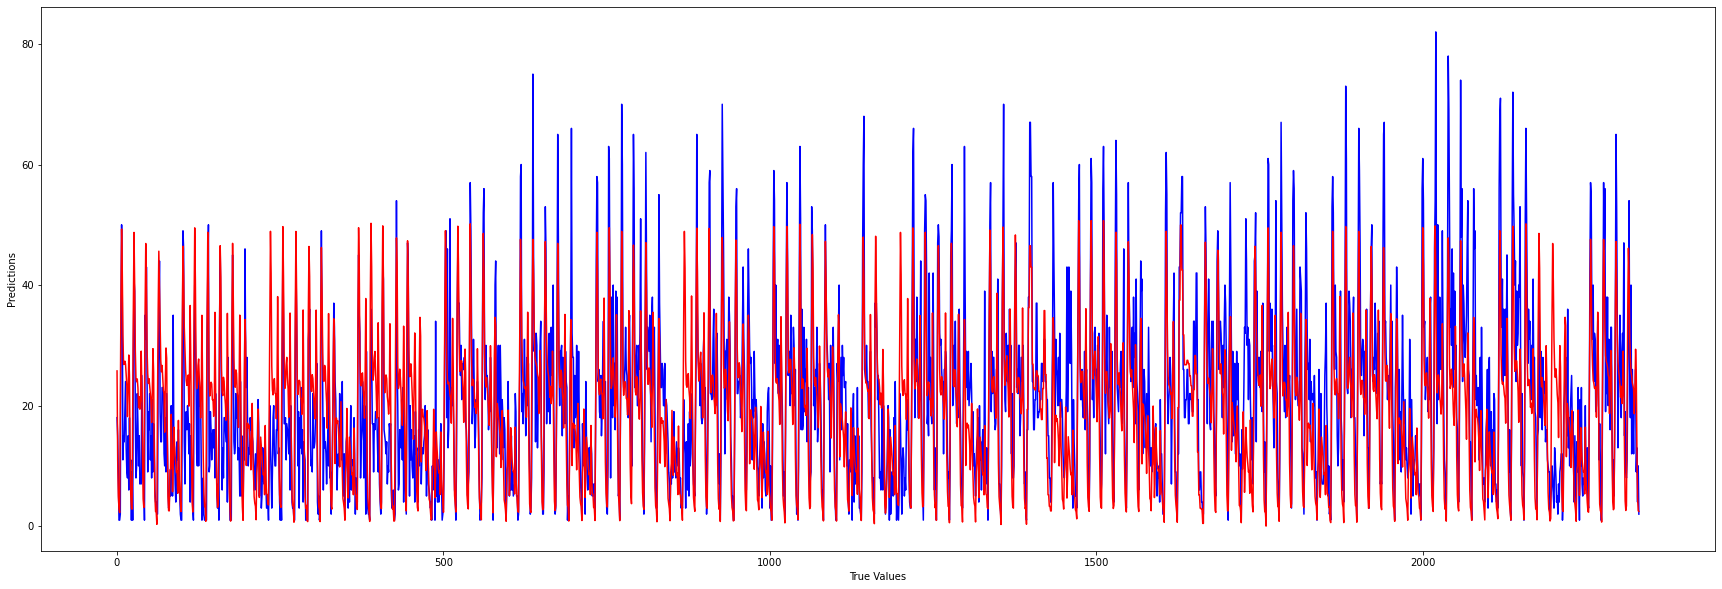

5212


In [24]:
#X_train, Y_train
#X_test, Y_test
#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
# X = line_data_model.filter(feature_names, axis=1)
# y = line_data_model.validations_per_hour

#quantos meses (comecando do final do dado) vou prever

# model_list = [
#     default_linearregression_model,
#     default_randomforest_model,
#     gridsearch_result_linearregression,
#     gridsearch_result_randomforest,
#     bagging_lr_model,
#     bagging_rf_model,
#     stack,
#     gradient_boosting_regressor
# ]

for hzp in range(4, 8):
    horizonte_de_previsao = hzp
    meses = line_data_model.mes.sort_values().unique()
    horizonte_de_treinamento = meses[:meses.size - horizonte_de_previsao]
    meses_de_previsao = meses[meses.size - horizonte_de_previsao:]

    predictions = [[],[],[],[],[],[],[],[]]
    performances = [[],[],[],[],[],[],[],[]]

    df_treinamento = line_data_model[line_data_model.mes.isin(horizonte_de_treinamento)].copy()
    df_previsao = line_data_model[line_data_model.mes.isin(meses_de_previsao)].copy()
    df_prev = df_previsao.filter(feature_names, axis = 1)
    df_results = df_previsao.filter('validations_per_hour', axis = 1)

    print(df_results.__len__())

    X = df_treinamento.filter(feature_names, axis=1)
    y = df_treinamento.validations_per_hour
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

    for i, model in enumerate(model_list):
        model.fit(X_train, Y_train)
        performances[i].append(get_performance(model))

        for index, row in df_prev.iterrows():
            predictions[i].append(model.predict([row])[0])
    
    df_results = df_previsao.validations_per_hour

    df_performance = pd.DataFrame(performances)
    df_performance.to_csv('./performances/performance_'+str(hzp)+'_meses.csv', index=False)

    plt_size = hzp * 360

    plt.figure(figsize=(30, 10))
    plt.plot(range(len(df_results) - plt_size), df_results[plt_size:], color='blue')
    plt.plot(range(len(predictions[0]) - plt_size ), predictions[2][plt_size:], color='red')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()

#print(predictions[0])


In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(range(len(df_results) - plt_size), df_results[plt_size:], color='blue')
plt.plot(range(len(predictions[2]) - plt_size ), predictions[0][plt_size:], color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [ ]:
performances

In [ ]:
df = pd.DataFrame(predictions)
df.to_csv('predictions0.csv', index=False)

In [ ]:
# ACCESS IN ORDER PREDICTION VALUES
df.iloc[0]

In [ ]:
# #top 100 exampled linhas
# #data_model.linha.value_counts().index[:100]

# print(data_model.linha.value_counts().index[:100])

d_31 = [1, 3, 5, 7, 8, 10, 12]
d_30 = [4, 6, 9, 11]


from datetime import datetime
import datetime
import calendar

def week_of_month(tgtdate):
    tgtdate = tgtdate.to_pydatetime()
    startdate = 0

    days_this_month = calendar.mdays[tgtdate.month]
    for i in range(1, days_this_month):
        d = datetime.datetime(tgtdate.year, tgtdate.month, i)
        if d.day - d.weekday() > 0:
            startdate = d
            break
    # now we canuse the modulo 7 appraoch
    return (tgtdate - startdate).days //7 + 1

# #ate outubro para prever novembro
# for linha in top100_linhas:
#     #linha filter
#     currentLinhaData = data_model[data_model.linha == linha]
#     print(currentLinhaData)
#     for mes in range(3, 12):
#         currentLinhaData = currentLinhaData[currentLinhaData.mes == mes]

#         if mes in d_31:
#             d_d = 31
#         elif mes in d_30:
#             d_d = 30
#         else:
#             d_d = 29
        
#         for dia in range(1, d_d):
#             currentLinhaData = currentLinhaData[currentLinhaData.d_mes == dia]
#             for hora in range(24):
#                 currentLinhaData = currentLinhaData[currentLinhaData.hora == hora]
#                 if currentLinhaData.empty:
#                     # feature_names = [
#                     # 'hour_sin', 'hour_cos', 
#                     # 'd_mes', 'mes', 'semana_do_mes', 
#                     # 'domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 
#                     # 'feriado', 'vespera_feriado']
#                     # target = 'validations_per_hour'

#                     # a_row = pd.Series([1, 2])
#                     # df = pd.DataFrame([[3, 4], [5, 6]])
#                     # row_df = pd.DataFrame([a_row])
#                     # df = pd.concat([row_df, df], ignore_index=True)

#                     h_sin = np.sin(2 * np.pi * hora/23.0)
#                     h_cos = np.cos(2 * np.pi * hora/23.0)
#                     semana_do_mes = (dia-1) // 7 + 1
#                     #dia do ano
#                     ins = pd.Series([linha, data_hora, 0, h_sin, h_cos, dia, mes, semana_do_mes *DIASDASEMANAENCODED, *feriado, *vesperaferiado])
#                     ins_df = pd.DataFrame([ins])

#                     currentLinhaData = pd.concat([ins_df, currentLinhaData], ignore_index=True)
#                     print(f"INSERINDO MISSING HORA {hora} no dia {dia} do mes {mes}")

# t = data_model[data_model.linha.isin(data_model.linha.value_counts().index[:100])]
# t

## Ranking Linhas de Onibus

In [ ]:

# print(data_model.linha.value_counts(ascending=True)[data_model['linha'].value_counts() < 100])

# linha_lista = data_model.linha.unique()
# linha_lista = linha_lista[:10]
res_map = list()
for linha in top100_linhas:
    for model in model_list:
        
        # X = currentLinhaData.filter(['hour_sin', 'hour_cos', 
        # 'd_mes', 'd_ano', 'mes', 'semana_do_mes', 
        # 'domingo','segunda', 'terca', 'quarta', 'quinta', 'sexta', 'sabado', 
        # 'feriado', 'vespera_feriado'], axis=1)
        # y = currentLinhaData.validations_per_hour

        currentLinhaData = top100_linhas_data_model.loc[data['linha'] == linha].copy()
        X = currentLinhaData.filter(feature_names, axis=1)
        y = currentLinhaData.validations_per_hour
        X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

        model.fit(X_train, Y_train)
        performance = get_performance(model)
        performance.insert(0, linha)
        res_map.append(performance)
res_map = pd.DataFrame(res_map, columns=["Linha", "R2", "RMSE", "MAE"])
r = res_map.sort_values('MAE', ascending=True)
r.to_csv("./performances/ranking_top100.csv", index=False)



In [ ]:
r.to_csv("./performances/ranking_top100.csv", index=False)
r

In [ ]:
# res_map = pd.DataFrame(res_map,columns=['Linha', 
#     # '[LR][DEF]R2', '[LR][DF]RMSE', '[LR][DF]MAE',
#     '[RF][GS]R2', '[RF][GS]RMSE', '[RF][GS]MAE',
#     # '[LR][BAG]R2', '[LR][BAG]RMSE', '[LR][BAG]MAE',
#     '[RF][BAG]R2', '[RF][BAG]RMSE', '[RF][BAG]MAE',
#     '[STK]R2', '[STK]RMSE', '[STK]MAE',
#     # '[BOS]R2', '[BOS]RMSE', '[BOS]MAE' 
#     ])
res_map = pd.DataFrame(res_map,columns=['Linha','R2', 'RMSE', 'MAE'])

#performance_scoring['Score'] = performance_scoring['Score'].astype('float64')
res_map = res_map.sort_values('R2').reset_index(drop=True)
res_map.to_csv('./top100linhas_rank.csv', index=False)
res_map

## Avaliacao dos dados atualmente
404 linhas  
358 com pelo menos 10 exemplos



In [ ]:
# res_map.to_csv('./classic-linha-comp.csv', index = False)